# Network State Index -- API demo

see: https://github.com/yzerlaut/Network_State_Index

We demonstrate the use of the API on the following publicly available dataset:

## the "Visual Coding – Neuropixels" dataset from the Allen Observatory

All details about this dataset and instructions for analysis are available at:

https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

We focus on the "functional_connectivity" dataset because it has 30 minutes of spontaneous activity  (we pick 20min in the center of that period).

![title](../doc/allen-dataset.png)

## Dataset download

I adapted the download instructions and made a [custom script](https://github.com/yzerlaut/Network_State_Index/blob/main/demo/download_Allen_Visual-Coding_dataset.py) to download exclusively the part of the dataset of interest here (i.e. V1 probes, ~20GB of LFP data).
You can run the script as:
```
python demo/download_Allen_Visual-Coding_dataset.py
```

In [3]:
# some general python / scientific-python modules
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
#plt.style.use('seaborn')
plt.style.use('ggplot')

# the Network State Index API, see: https://github.com/yzerlaut/Network_State_Index
# install it with: "pip install git+https://github.com/yzerlaut/Network_State_Index"
import nsi


V1_Allen_params = {'pLFP_band':[40,140], # Hz -- paper's values 
                   'delta_band':[4,8], # Hz -- the delta peaks at 6hz, not 3hz..
                   'Tsmoothing':30e-3,  # s -- slightly lower smoothing because the 42ms smoothing of S1 smooth out a bit too much the delta in V1
                   'alpha_LFP':3., # evaluated below
                   'alpha_rate':2} # the rate is a virtually noiseless signal (it defines Network States), so no need to be >2 (see paper's derivation)

### We restrict the analysis to:

- wild type / wild type strain
- male
- sessions with probes in V1 ("VISp")
- "functional_connectivity" dataset (because it has 30min of spontaneous activity)

In [4]:
# Download and load the data with the "allensdk" API
# get the "allensdk" api with: "pip install allensdk"
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# now let's define a cache repository for the data: by default ~/Downloads/ecephys_cache_dir
# insure that you have a "Downloads" repository in your home directory (/!\ non-english systems) or update below
data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
all_sessions = cache.get_session_table() # get all sessions

# let's filter the sessions according to the above criteria
sessions = all_sessions[(all_sessions.sex == 'M') & \
                        (all_sessions.full_genotype.str.find('wt/wt') > -1) & \
                        #(all_sessions.session_type == 'brain_observatory_1.1') & \
                        (all_sessions.session_type == 'functional_connectivity') & \
                        (['VISp' in acronyms for acronyms in all_sessions.ecephys_structure_acronyms])]
print(30*'--'+'\n--> Number of sessions with the desired characteristics: ' + str(len(sessions))+'\n'+30*'--')
# sessions.head() # uncomment to see how they look

------------------------------------------------------------
--> Number of sessions with the desired characteristics: 11
------------------------------------------------------------


## Loading, formatting and preprocessing the data

In [5]:
import time

   
class Data:
    """
    an object to load, format and process the data
    we use the Allen SDK to fetch the V1 channels
    
    we format things so that data are accessible as: "data.QUANTITY" with time sampling data.t_QUANTITY (e.g. "data.pLFP", "data.t_pLFP")
    """
    
    def __init__(self, 
                 session_index=0,
                 reduced=False,
                 t0=115*60, 
                 duration=20*60, # 20 min by default
                 #init=['pop_act', 'pLFP', 'NSI'], # for a full init
                 init = []):
        """
        loading data:
        - the Allen NWB files are loaded by default, select the session according to the index of the "sessions" above
        - for initial troubleshooting, there is a "demo" option that loads a lightweight data sample provided in the repo
        - for faster analysis alter (to loop over the data), we can load the "reduced" version of the data of interest (generated below)


        can load a subset using the "t0" and "duration" args
        """
        
        if reduced:
            rdata = np.load('reduced_data/Allen_FC_session%i.npy' % (session_index+1), allow_pickle=True).item()
            for key in rdata:
                setattr(self, key, rdata[key]) # sets LFP, pLFP, pop_act, running_speed
            for key in ['LFP', 'pLFP', 'pop_act']:
                setattr(self, 't_%s'%key, np.arange(len(getattr(self,key)))/getattr(self,'%s_sampling_rate'%key)+self.t0)
        else:
            # -------------------------------------------------------- # 
            # -- using the Allen SDK to retrieve and cache the data -- #
            # -------------------------------------------------------- # 

            print('loading session #%i [...]' % (1+session_index))
            tic = time.time()
            # we load a single session
            session = cache.get_session_data(sessions.index.values[session_index])
            
            # use the running timestamps to set start and duration in the data object
            self.t0 = np.max([t0, session.running_speed.start_time.values[0]])
            self.duration = np.min([duration, session.running_speed.end_time.values[-1]-self.t0])

            # let's fetch the running speed
            cond = (session.running_speed.end_time.values>self.t0) &\
                (session.running_speed.start_time.values<(self.t0+self.duration))
            self.t_running_speed = .5*(session.running_speed.start_time.values[cond]+\
                                       session.running_speed.end_time.values[cond])
            self.running_speed = session.running_speed.velocity[cond]

            # let's fetch the isolated single units in V1
            V1_units = session.units[session.units.ecephys_structure_acronym == 'VISp'] # V1==VISp
            self.V1_RASTER = []
            for i in V1_units.index:
                cond = (session.spike_times[i]>=self.t0) & (session.spike_times[i]<(self.t0+self.duration))
                self.V1_RASTER.append(session.spike_times[i][cond])

            # let's fetch the V1 probe --> always on "probeC"
            probe_id = session.probes[session.probes.description == 'probeC'].index.values[0]

            # -- let's fetch the lfp data for that probe and that session --
            # let's fetch the all the channels falling into V1 domain
            self.V1_channel_ids = session.channels[(session.channels.probe_id == probe_id) & \
                          (session.channels.ecephys_structure_acronym.isin(['VISp']))].index.values

            # limit LFP to desired times and channels
            # N.B. "get_lfp" returns a subset of all channels above
            self.lfp_slice_V1 = session.get_lfp(probe_id).sel(time=slice(self.t0,
                                                                         self.t0+self.duration),
                                                              channel=slice(np.min(self.V1_channel_ids), 
                                                                            np.max(self.V1_channel_ids)))
            self.Nchannels_V1 = len(self.lfp_slice_V1.channel) # store number of channels with LFP in V1
            self.lfp_sampling_rate = session.probes.lfp_sampling_rate[probe_id] # keeping track of sampling rate
            
            try:
                pupil = session.get_pupil_data()
                self.pupil_area = np.pi*pupil['pupil_height'].values/2.*pupil['pupil_width'].values/2.
                self.t_pupil_area = pupil.index.values
            except BaseException:
                self.pupil_area, self.t_pupil_area = None, None                
                
            print('data successfully loaded in %.1fs' % (time.time()-tic))
              
        for key in init:
            getattr(self, 'compute_%s' % key)()
            

    def update_t0_duration(self, t0, duration):
        t0 = t0 if (t0 is not None) else self.t0
        duration = duration if (duration is not None) else self.duration
        return t0, duration
    
        
    def compute_pop_act(self, 
                        pop_act_bin=5e-3,
                        pop_act_smoothing=V1_Allen_params['Tsmoothing']):
        """
        we bin spikes to compute population activity
        """
        print(' - computing pop_act from raster [...]') 
        t_pop_act = self.t0+np.arange(int(self.duration/pop_act_bin)+1)*pop_act_bin
        pop_act = np.zeros(len(t_pop_act)-1)

        for i, spikes in enumerate(self.V1_RASTER):
            pop_act += np.histogram(spikes, bins=t_pop_act)[0]
        pop_act /= (len(self.V1_RASTER)*pop_act_bin)

        self.t_pop_act = .5*(t_pop_act[1:]+t_pop_act[:-1])
        self.pop_act = nsi.gaussian_filter1d(pop_act, 
                                             int(pop_act_smoothing/pop_act_bin)) # filter from scipy
        self.pop_act_sampling_rate = 1./pop_act_bin
        print(' - - > done !')             
        
    def compute_NSI(self, quantity='pLFP',
                    low_freqs = np.linspace(*V1_Allen_params['delta_band'], 5),
                    p0_percentile=1.,
                    alpha=2.87,
                    T_sliding_mean=500e-3,
                    with_subquantities=True,
                    verbose=True):
        """
        ------------------------------
            HERE we use the NSI API
        ------------------------------
        """
        if verbose:
            print(' - computing NSI for "%s" [...]' % quantity) 
        setattr(self, '%s_0' % quantity, np.percentile(getattr(self, quantity), p0_percentile/100.))
        
        lfe, sm, NSI = nsi.compute_NSI(getattr(self, quantity),
                                       getattr(self, '%s_sampling_rate' % quantity),
                                       low_freqs = low_freqs,
                                       p0=getattr(self, '%s_0' % quantity),
                                       alpha=alpha,
                                       T_sliding_mean=T_sliding_mean, 
                                       with_subquantities=True) # we fetch also the NSI subquantities (low-freq env and sliding mean), set below !
        setattr(self, '%s_low_freq_env' % quantity, lfe)
        setattr(self, '%s_sliding_mean' % quantity, sm)
        setattr(self, '%s_NSI' % quantity, NSI)
        if verbose:
            print(' - - > done !') 
        
    def validate_NSI(self, quantity='pLFP',
                     Tstate=200e-3,
                     var_tolerance_threshold=None,
                     verbose=True):
        """
        ------------------------------
            HERE we use the NSI API
        ------------------------------
        """
        if verbose:
            print(' - validating NSI for "%s" [...]' % quantity) 
        
        if var_tolerance_threshold is None:
            # by default the ~noise level evaluated as the first percentile
            var_tolerance_threshold = getattr(self, '%s_0' % quantity)
 
        vNSI = nsi.validate_NSI(getattr(self, 't_%s' % quantity),
                                getattr(self, '%s_NSI' % quantity),
                                Tstate=Tstate,
                                var_tolerance_threshold=var_tolerance_threshold)
    
        setattr(self, 'i_%s_vNSI' % quantity, vNSI)
        setattr(self, 't_%s_vNSI' % quantity, getattr(self, 't_%s' % quantity)[vNSI])
        setattr(self, '%s_vNSI' % quantity, getattr(self, '%s_NSI' % quantity)[vNSI])
        if verbose:
            print(' - - > done !')
        
    def plot(self, quantity, 
             t0=None, duration=None,
             ax=None, label='',
             subsampling=1,
             color='k', ms=0, lw=1, alpha=1):
        """
        a general plot function for the quantities of this object
        
        quantity as a string (e.g. "pLFP" or "running_speed")
        """
        
        t0, duration = self.update_t0_duration(t0, duration)
        
        try:
            if ax is None:
                fig, ax =plt.subplots(1, figsize=(8,3))
            else:
                fig = None
            t = getattr(self, 't_'+quantity.replace('_NSI','').replace('_low_freq_env','').replace('_sliding_mean',''))
            signal = getattr(self, quantity)
            cond = (t>t0) & (t<(t0+duration))
            ax.plot(t[cond][::subsampling], signal[cond][::subsampling], color=color, lw=lw, ms=ms, marker='o', alpha=alpha)
            ax.set_ylabel(label)
            return fig, ax
        except BaseException as be:
            print(be)
            print('%s not a recognized attribute to plot' % quantity)
            return None, None
        
from scipy.interpolate import interp1d
# a tool very useful to 
def resample_trace(old_t, old_data, new_t):
    func = interp1d(old_t, old_data, kind='nearest', fill_value="extrapolate")
    return func(new_t)


## Channel selection in LFP recordings with Neuropixel probes

We benefit from many channels in the area of interest (~20 in V1). How to deal with this ? 

--> simple solution: we pick just one channel, the one that has the highest delta envelope in the pLFP. This sounds like a good guess for a channel with good physiological signal.

In [41]:
def find_channel_with_highest_delta(data,
                                    t0=None, duration=None,
                                    pLFP_band=V1_Allen_params['pLFP_band'],
                                    delta_band=V1_Allen_params['delta_band'],
                                    pLFP_subsampling=5,
                                    return_all=False):
    """
    A function to pick the channel with the highest average pLFP delta envelope
    """
    channel_mean_delta, channel_id, final_pLFP, final_LFP = 0, None, None, None

    
    ALL = None
    if return_all:
        ALL = {'LFP':[], 'pLFP':[], 't':data.lfp_slice_V1.time}

    for c in range(len(data.lfp_slice_V1.channel.values)):
        # first get the LFP
        LFP = 1e3*np.array(data.lfp_slice_V1.sel(channel=data.lfp_slice_V1.channel[c]))
        if return_all:
            ALL['LFP'].append(LFP)
        # then compute the pLFP            === USING the *nsi* API ===
        _, pLFP = nsi.compute_pLFP(LFP, data.lfp_sampling_rate,
                                   smoothing=V1_Allen_params['Tsmoothing'])
        if return_all:
            ALL['pLFP'].append(1e3*pLFP)
        # compute low freq envelope of pLFP (subsampled on need of full sampling)
        lf_env = nsi.compute_freq_envelope(1e3*pLFP[::pLFP_subsampling], 
                                           data.lfp_sampling_rate/pLFP_subsampling,
                                           np.linspace(delta_band[0], delta_band[1], 5))
        
        if np.mean(lf_env)>channel_mean_delta:
            channel_mean_delta = np.mean(lf_env)
            final_LFP = LFP
            final_pLFP = 1e3*pLFP
            channel_id = c
    return final_LFP, final_pLFP, channel_id, ALL


In [6]:
data = Data(session_index=0, 
            init=['pop_act'])

final_LFP, final_pLFP, channel_id, ALL = find_channel_with_highest_delta(data,
                                                                         return_all=True)

loading session #3 [...]
This ecephys session '768515987' has no eye tracking data. (NWB error: "'eye_tracking' not found in processing of NWBFile 'root'.")
data successfully loaded in 34.0s
 - computing pop_act from raster [...]
 - - > done !


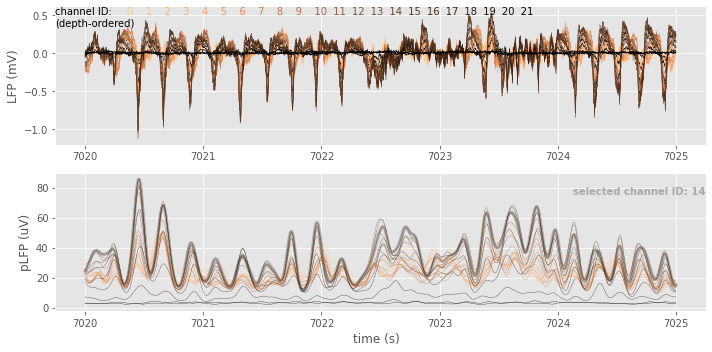

In [9]:
t0, duration = data.t0+120, 5 # showing a sample with some nice sinal variations
fig, AX = plt.subplots(2, figsize=(10,5))
cmap = plt.cm.copper

cond = (ALL['t']>t0) & (ALL['t']<(t0+duration))
AX[1].plot(ALL['t'][cond], final_pLFP[cond], lw=3, color='darkgrey')
for i in range(len(ALL['LFP'])):
    AX[0].plot(ALL['t'][cond], ALL['LFP'][i][cond], lw=0.3, color=cmap(1-i/(data.Nchannels_V1-1)))
    AX[1].plot(ALL['t'][cond], ALL['pLFP'][i][cond], lw=0.3, color=cmap(1-i/(data.Nchannels_V1-1)))
        
#data.plot('pop_act', ax=AX[2], t0=t0, duration=duration)
#AX[2].set_ylabel('rate (Hz)  ')
AX[1].set_xlabel('time (s)  ')
AX[0].set_ylabel('LFP (mV)')
AX[1].set_ylabel('pLFP (uV)')
AX[1].annotate('selected channel ID: %i' % channel_id,
               (1,.9), xycoords='axes fraction', va='top', ha='right',color='darkgrey', weight='bold')
for i in range(data.Nchannels_V1):
    AX[0].annotate((i+1)*'      '+'                 %i' % i, (0,1), xycoords='axes fraction', va='top',
                color=cmap(1-i/(data.Nchannels_V1-1)))
AX[0].annotate('channel ID:\n(depth-ordered)', (0,1), xycoords='axes fraction', va='top');
plt.tight_layout()
#fig.savefig('../doc/Neuropixels-channel-selection.png')

### Now we loop over all sessions to get the reduced data with those properties

In [ ]:
# takes about 10 minutes on a good desktop computer

def save_reduced_data(data, session_index, LFP, pLFP, channel_id):
    new_data = {'t0':data.t0, 'duration':data.duration,
                'V1_RASTER':data.V1_RASTER,
                'pop_act':data.pop_act, 'pop_act_sampling_rate':data.pop_act_sampling_rate,
                'selected_channel_id':channel_id,
                'LFP':LFP, 'LFP_sampling_rate':data.lfp_sampling_rate,
                'pLFP':pLFP, 'pLFP_sampling_rate':data.lfp_sampling_rate,
                'pupil_area':data.pupil_area,'t_pupil_area':data.t_pupil_area,
                't_running_speed':data.t_running_speed, 'running_speed':data.running_speed,
               }
    np.save('reduced_data/Allen_FC_session%i.npy' % (session_index+1), new_data)

    
for session_index in range(len(sessions)):
    
    data = Data(session_index=session_index, reduced=False, demo=False,
                init=['pop_act'])
    print('looking for the best recording channel [...]')
    LFP, pLFP, channel_id, _ = find_channel_with_highest_delta(data)
    save_reduced_data(data, session_index, LFP, pLFP, channel_id)
    

## Characterizing the delta oscillation in V1

In [10]:
freqs = np.linspace(1, 10, 40)

envelope = np.zeros((len(freqs), len(sessions)))

for i in range(len(sessions)):
    data = Data(session_index=i, reduced=True)
    # wavelet transform using "NSI"
    envelope[:,i] = 1e3*np.abs(nsi.my_cwt(data.LFP, freqs, 
                                      1./data.LFP_sampling_rate)).mean(axis=1)


In [11]:
max_env_levels = [freqs[np.argmax(envelope[:,i])] for i in range(len(sessions))]
print('in V1, delta peak at: %.1f +/- %.1f Hz' % (np.mean(max_env_levels), np.std(max_env_levels)))

in V1, delta peak at: 5.7 +/- 0.6 Hz


In [12]:
# let's compare to S1, loading a reduced dataset per cell

if os.path.isfile('reduced_data/reduced_data_cell_1.npz'):
    # if you have the S1 data, let's do the same on S1
    envelope_S1 = np.zeros((len(freqs), 14))
    for i in np.arange(1, 15):
        data = dict(np.load('reduced_data/reduced_data_cell_'+str(i)+'.npz'))
        envelope_S1[:,i-1] = 1e3*np.abs(nsi.my_cwt(data['sbsmpl_Extra'], freqs, 
                                             data['sbsmpl_dt'])).mean(axis=1)
else:
    envelope_S1 = None

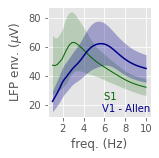

In [14]:
fig, ax = plt.subplots(1, figsize=(2.3,2.3))

if envelope_S1 is not None:
    ax.plot(freqs, envelope_S1.mean(axis=1), color='darkgreen', lw=1)
    ax.fill_between(freqs, 
                     envelope_S1.mean(axis=1)-envelope_S1.std(axis=1),
                     envelope_S1.mean(axis=1)+envelope_S1.std(axis=1), color='darkgreen', alpha=0.2, lw=0)
    ax.annotate('S1           \n', (1,0.05), color='darkgreen', xycoords='axes fraction', ha='right')
    
ax.plot(freqs, envelope.mean(axis=1), color='darkblue')
ax.fill_between(freqs, 
                 envelope.mean(axis=1)-envelope.std(axis=1),
                 envelope.mean(axis=1)+envelope.std(axis=1), color='darkblue', alpha=0.3, lw=0)
ax.annotate('V1 - Allen', (1,0.05), color='darkblue', xycoords='axes fraction', ha='right')
ax.set_xticks([2,4,6,8,10])
ax.set_xlabel('freq. (Hz)')
ax.set_ylabel('pLFP env. ($\mu$V)')
plt.tight_layout()
fig.savefig('../doc/delta-oscill-comparison.svg')

## Find the optimal $\alpha$ parameter

this loop over session and $\alpha$ values is a bit long to run, ~15min

In [15]:
alpha_values = np.linspace(1.5, 7, 12)

output = np.zeros((len(sessions), len(alpha_values)))
for i in range(len(sessions)):
    #print('session', i)
    data = Data(session_index=i, reduced=True)
    data.compute_NSI(quantity='pop_act', alpha=2, verbose=False)
    for a, alpha in enumerate(alpha_values):
        data.compute_NSI(quantity='pLFP',
                         alpha=alpha,
                         p0_percentile=1,
                         verbose=False)
        data.validate_NSI(quantity='pLFP', verbose=False)
        pop_act_low_freq_env = resample_trace(data.t_pop_act, data.pop_act_low_freq_env, data.t_pLFP)
        delta_cond_validated = data.i_pLFP_vNSI & (data.pLFP_NSI<0)
        output[i, a] = np.mean(pop_act_low_freq_env[delta_cond_validated])

/home/yann.zerlaut/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann.zerlaut/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


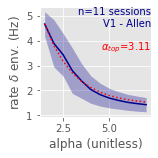

In [17]:
# plotting and fitting the decay
fig, ax = plt.subplots(1, figsize=(2.3,2.3))

# fitting an exponential
from scipy.optimize import curve_fit
def exp(t, decay,
        t0=alpha_values[0],
        x0=np.nanmean(output, axis=0)[-1],
        x1=np.nanmean(output, axis=0)[0]):
    return x0+(x1-x0)*np.exp(-(t-t0)/decay)
fit = curve_fit(exp, alpha_values, np.nanmean(output, axis=0), p0=10)
    
# plotting
ax.plot(alpha_values, np.nanmean(output, axis=0), color='darkblue')
ax.plot(alpha_values, exp(alpha_values, fit[0]), 'r:')
ax.annotate('$\\alpha_{top}$=%.2f' % (alpha_values[0]+fit[0]), (1,.7), ha='right', va='top', xycoords='axes fraction', color='r')
ax.fill_between(alpha_values, 
                 np.nanmean(output, axis=0)-np.nanstd(output, axis=0),
                 np.nanmean(output, axis=0)+np.nanstd(output, axis=0),color='darkblue', alpha=0.3, lw=0)
ax.annotate('n=11 sessions\nV1 - Allen', (1,1), ha='right', va='top', xycoords='axes fraction', color='darkblue')
ax.set_xlabel('alpha (unitless)')
ax.set_ylabel('rate $\delta$ env. (Hz)')
plt.tight_layout()
#fig.savefig('../doc/alpha-delta-dep.svg')

## Characterizing Network State Distributions

In [4]:
DATA = []
for i in range(len(sessions)):
    data = Data(session_index=i, reduced=True)
    data.compute_NSI(quantity='pLFP',
                     alpha=3.11,
                     p0_percentile=1,
                     verbose=False)
    data.validate_NSI(quantity='pLFP', verbose=False)
    data.compute_NSI(quantity='pop_act',
                     alpha=2,
                     p0_percentile=1,
                     verbose=False)
    DATA.append(data)

In [5]:
NSI_bins = np.linspace(-50, 80, 50)
NSI_hist = np.zeros((len(sessions), len(NSI_bins)-1))
for i, data in enumerate(DATA):
    NSI_hist[i,:] = np.histogram(data.pLFP_vNSI, bins=NSI_bins, density=True)[0]

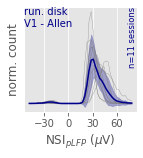

In [6]:
fig, ax = plt.subplots(1, figsize=(2.1,2.3))
x = .5*(NSI_bins[1:]+NSI_bins[:-1])
for i in range(NSI_hist.shape[0]):
    ax.plot(x, NSI_hist[i,:], '-', lw=0.3, color='grey')
ax.annotate('run. disk\nV1 - Allen', (0,1), xycoords='axes fraction', color='darkblue', va='top')
ax.annotate('n=11 sessions', (1,1), xycoords='axes fraction', color='darkblue', va='top', ha='right', rotation=90, size='small')
ax.plot(x, NSI_hist.mean(axis=0), '-', color='darkblue')
ax.fill_between(x, NSI_hist.mean(axis=0)-NSI_hist.std(axis=0), NSI_hist.mean(axis=0)+NSI_hist.std(axis=0), color='darkblue', alpha=.3)
ax.set_ylabel('norm. count')
ax.set_yticks([])
ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
ax.set_xticks([-30,0,30,60])
plt.tight_layout()
fig.savefig('../doc/V1-NSI-hist.svg')

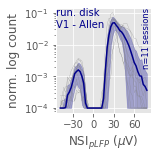

In [7]:
minc=1e-4 # min count
fig, ax = plt.subplots(1, figsize=(2.3,2.3))
x = .5*(NSI_bins[1:]+NSI_bins[:-1])
for i in range(NSI_hist.shape[0]):
    ax.plot(x, NSI_hist[i,:]+minc, '-', lw=0.2, color='grey')
ax.annotate('run. disk\nV1 - Allen', (0,1), xycoords='axes fraction', color='darkblue', va='top')
ax.annotate('n=11 sessions', (1,1), xycoords='axes fraction', color='darkblue', va='top', ha='right', rotation=90, size='small')
mean = NSI_hist.mean(axis=0)
mean[mean<minc] = minc
ax.plot(x, mean, '-', color='darkblue')
lb, hb = NSI_hist.mean(axis=0)-NSI_hist.std(axis=0), NSI_hist.mean(axis=0)+NSI_hist.std(axis=0)
lb[lb<minc]=minc
hb[hb<minc]=minc
ax.fill_between(x, lb, hb, color='darkblue', alpha=.3)
ax.set_ylabel('norm. log count')
ax.set_yticks([])
ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
ax.set_xticks([-30,0,30,60])
plt.yscale('log')
plt.tight_layout()
fig.savefig('../doc/V1-NSI-log-hist.svg')

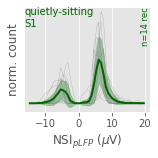

In [27]:
# let's compare to S1, loading a reduced dataset per cell

NSI_bins_S1 = np.linspace(-15, 20, 50)

if os.path.isfile('reduced_data/reduced_data_cell_1.npz'):
    # if you have the S1 data, let's do the same on S1
    NSI_hist_S1 = np.zeros((14, len(NSI_bins_S1)-1))
    for i in np.arange(1, 15):
        data = dict(np.load('reduced_data/reduced_data_cell_'+str(i)+'.npz'))
        NSI_hist_S1[i-1,:] = np.histogram(data['NSI'][data['NSI_validated']], bins=NSI_bins_S1, density=True)[0]
    # plot
    fig, ax = plt.subplots(1, figsize=(2.3,2.3))
    x = .5*(NSI_bins_S1[1:]+NSI_bins_S1[:-1])
    for i in range(NSI_hist_S1.shape[0]):
        ax.plot(x, NSI_hist_S1[i,:], '-', lw=0.2, color='grey')

    ax.annotate('quietly-sitting\nS1', (0,1), xycoords='axes fraction', color='darkgreen', va='top')
    ax.annotate('n=14 rec', (1,1), xycoords='axes fraction', color='darkgreen', va='top', ha='right', rotation=90, size='small')
    ax.plot(x, NSI_hist_S1.mean(axis=0), lw=2, color='darkgreen')
    ax.fill_between(x, NSI_hist_S1.mean(axis=0)-NSI_hist_S1.std(axis=0), NSI_hist_S1.mean(axis=0)+NSI_hist_S1.std(axis=0), color='darkgreen', alpha=.3)
    ax.set_ylabel('norm. count')
    ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
    ax.set_yticks([])
    ax.set_xticks([-10,0,10,20])   
    plt.tight_layout()
    fig.savefig('../doc/S1-NSI-hist.svg')
else:
    print(' S1 data not found')

## Studying the population rate correlate of NSI$_{pLFP}$-based network states

In [26]:
NSI_bins_neg = np.linspace(-40, 0, 15)
NSI_bins_pos = np.linspace(0, 65, 20)
Nmin_episode = 5 # a minimum episode condition for each level (to get a meaningful average)

delta_env_rhythmic = np.zeros((len(sessions), len(NSI_bins_neg)))
std_delta_env_rhythmic = np.zeros((len(sessions), len(NSI_bins_neg)))

mean_level_nonrhythmic = np.zeros((len(sessions), len(NSI_bins_pos)))
std_level_nonrhythmic = np.zeros((len(sessions), len(NSI_bins_pos)))

for i, data in enumerate(DATA):
    # NSI < 0
    pop_act_low_freq_env = resample_trace(data.t_pop_act, data.pop_act_low_freq_env, data.t_pLFP)
    rhythmic_cond_validated = data.i_pLFP_vNSI & (data.pLFP_NSI<0)
    indices = np.digitize(data.pLFP_NSI[rhythmic_cond_validated], bins=NSI_bins_neg)
    for k in range(len(NSI_bins_neg)):
        if np.sum(indices==k)>=Nmin_episode:
            delta_env_rhythmic[i,k] = np.mean(pop_act_low_freq_env[rhythmic_cond_validated][indices==k])
            std_delta_env_rhythmic[i,k] = np.std(pop_act_low_freq_env[rhythmic_cond_validated][indices==k])
        else:
            delta_env_rhythmic[i,k] = np.nan
            std_delta_env_rhythmic[i,k] = np.nan
            
    # NSI > 0
    nonrhythmic_cond_validated = data.i_pLFP_vNSI & (data.pLFP_NSI>0)
    pop_act_mean = resample_trace(data.t_pop_act, data.pop_act_sliding_mean, data.t_pLFP)
    indices = np.digitize(data.pLFP_NSI[nonrhythmic_cond_validated], bins=NSI_bins_pos)
    for k in range(len(NSI_bins_pos)):
        if np.sum(indices==k)>=Nmin_episode:
            mean_level_nonrhythmic[i,k] = np.mean(pop_act_mean[nonrhythmic_cond_validated][indices==k])
            std_level_nonrhythmic[i,k] = np.std(pop_act_mean[nonrhythmic_cond_validated][indices==k])
        else:
            mean_level_nonrhythmic[i,k] = np.nan
            std_level_nonrhythmic[i,k] = np.nan

Text(0.5, 0, 'NSI$_{pLFP}$ ($\\mu$V)')

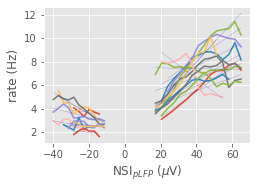

In [27]:
from scipy.stats import ttest_1samp
fig, ax = plt.subplots(1, figsize=(3.7,2.5))

neg_slopes, pos_slopes = [], []

for i in range(len(DATA)):
    # slopes in NSI<0 states
    cond = np.isfinite(delta_env_rhythmic[i,:])  
    if np.sum(cond)>2:
        pol = np.polyfit(NSI_bins_neg[cond], delta_env_rhythmic[i,cond], 1)
        ax.plot(NSI_bins_neg[cond], delta_env_rhythmic[i,cond])
        ax.plot(NSI_bins_neg[cond], np.polyval(pol, NSI_bins_neg[cond]), '--', color='darkblue', lw=0.2)
        neg_slopes.append(pol[0])
    # slopes in NSI<0 states
    cond = np.isfinite(mean_level_nonrhythmic[i,:])  
    if np.sum(cond)>2:
        pol = np.polyfit(NSI_bins_pos[cond], mean_level_nonrhythmic[i,cond], 1)
        ax.plot(NSI_bins_pos[cond], mean_level_nonrhythmic[i,cond])
        ax.plot(NSI_bins_pos[cond], np.polyval(pol, NSI_bins_pos[cond]), '--', color='darkblue', lw=0.2)
        pos_slopes.append(pol[0])
        
ax.set_ylabel('rate (Hz)')
ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')

/tmp/ipykernel_15819/2405741348.py:7: RuntimeWarning: Mean of empty slice
  cond = np.isfinite(np.nanmean(delta_env_rhythmic, axis=0))
/tmp/ipykernel_15819/2405741348.py:8: RuntimeWarning: Mean of empty slice
  pol = np.polyfit(NSI_bins_neg[cond], np.nanmean(delta_env_rhythmic, axis=0)[cond], 1)
/tmp/ipykernel_15819/2405741348.py:13: RuntimeWarning: Mean of empty slice
  cond = np.isfinite(np.nanmean(mean_level_nonrhythmic, axis=0))
/tmp/ipykernel_15819/2405741348.py:14: RuntimeWarning: Mean of empty slice
  pol = np.polyfit(NSI_bins_pos[cond], np.nanmean(mean_level_nonrhythmic, axis=0)[cond], 1)
/tmp/ipykernel_15819/2405741348.py:20: RuntimeWarning: Mean of empty slice
  ax.plot(NSI_bins_neg, np.nanmean(delta_env_rhythmic, axis=0), color=plt.cm.tab10(4))
/tmp/ipykernel_15819/2405741348.py:21: RuntimeWarning: Mean of empty slice
  ax.fill_between(NSI_bins_neg, np.nanmean(delta_env_rhythmic, axis=0)-np.nanstd(delta_env_rhythmic, axis=0),
/home/yann.zerlaut/miniconda3/lib/python3.9/site-

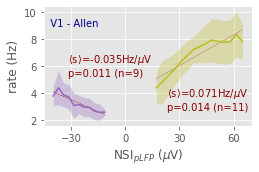

In [34]:
# N.B. we use "np.nan" has a flag for "no episodes in that range" (see above) so the average generates some warning
from scipy.stats import pearsonr, ttest_1samp

fig, ax = plt.subplots(1, figsize=(3.7,2.5))
    
# statistical analysis for the NSI vs delta envelope relationship in NSI<0 states
cond = np.isfinite(np.nanmean(delta_env_rhythmic, axis=0))
pol = np.polyfit(NSI_bins_neg[cond], np.nanmean(delta_env_rhythmic, axis=0)[cond], 1)
ax.plot(NSI_bins_neg[cond], np.polyval(pol, NSI_bins_neg[cond]), '--', color='darkred', lw=0.5)
ax.annotate(r'$\langle$s$\rangle$=%.3fHz/$\mu$V'%np.mean(neg_slopes)+'\n'+'p=%.3f (n=%i)'%(ttest_1samp(neg_slopes, 0).pvalue, len(neg_slopes)),
            (-32,5.3), color='darkred')

cond = np.isfinite(np.nanmean(mean_level_nonrhythmic, axis=0))
pol = np.polyfit(NSI_bins_pos[cond], np.nanmean(mean_level_nonrhythmic, axis=0)[cond], 1)
ax.plot(NSI_bins_pos[cond], np.polyval(pol, NSI_bins_pos[cond]), '--', color='darkred', lw=0.3)
ax.annotate(r'$\langle$s$\rangle$=%.3fHz/$\mu$V'%np.mean(pos_slopes)+'\n'+'p=%.3f (n=%i)'%(ttest_1samp(pos_slopes, 0).pvalue, len(pos_slopes)),
            (68,4.5), color='darkred', ha='right', va='top')


ax.plot(NSI_bins_neg, np.nanmean(delta_env_rhythmic, axis=0), color=plt.cm.tab10(4))
ax.fill_between(NSI_bins_neg, np.nanmean(delta_env_rhythmic, axis=0)-np.nanstd(delta_env_rhythmic, axis=0), 
                np.nanmean(delta_env_rhythmic, axis=0)+np.nanstd(delta_env_rhythmic, axis=0), alpha=0.3, lw=0, color=plt.cm.tab10(4))

ax.plot(NSI_bins_pos, np.nanmean(mean_level_nonrhythmic, axis=0), color=plt.cm.tab10(8))
ax.fill_between(NSI_bins_pos, np.nanmean(mean_level_nonrhythmic, axis=0)-np.nanstd(mean_level_nonrhythmic, axis=0), 
                np.nanmean(mean_level_nonrhythmic, axis=0)+np.nanstd(mean_level_nonrhythmic, axis=0), alpha=0.3, lw=0, color=plt.cm.tab10(8))

ax.annotate('\n  V1 - Allen', (0,1), xycoords='axes fraction', color='darkblue', va='top')

ax.set_ylabel('rate (Hz)')
ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
ax.set_xticks([-30,0,30,60])
plt.tight_layout()
#fig.savefig('../doc/V1-pop-rate-dep.svg')

## We plot sample data and single session average

In [35]:
def plot_sample_data(data, title='',
                     time_points=[100, 1000], 
                     episode_ids=[],
                     duration=2):


    fig, AX_full = plt.subplots(6,len(time_points), figsize=(2.3*len(time_points), 6))
    fig.suptitle(title, size='small')
    
    if len(time_points)==1:
        AX_full = [AX_full]
        
    YLIMS = [[np.inf, -np.inf] for i in range(len(AX_full))]
                   
    for k, t0, ep, AX in zip(range(len(time_points)), time_points, episode_ids, AX_full.T):
        
        # raster plot
        if hasattr(data, 'V1_RASTER'):
            for i, spikes in enumerate(data.V1_RASTER):
                cond = (spikes>t0) & (spikes<(t0+duration))
                AX[0].plot(spikes[cond], i+0*spikes[cond], 'o', ms=0.4, color='darkblue')
                
        AX[0].set_ylabel('units')
        
        # pop act. plot
        data.plot('pop_act', t0=t0, duration=duration, ax=AX[1], color='darkblue')
        data.plot('pop_act_sliding_mean', t0=t0, duration=duration, ax=AX[1], color='darkblue', lw=5, alpha=.2)
        
        # LFP plot
        data.plot('LFP', t0=t0, duration=duration, ax=AX[2], color='dimgrey')
        
        # pLFP plot
        data.plot('pLFP', t0=t0, duration=duration, ax=AX[3], color=plt.cm.tab10(5))
        data.plot('pLFP_sliding_mean', t0=t0, duration=duration, ax=AX[3], color=plt.cm.tab10(5), lw=5, alpha=.2)

        # NSI plot
        AX[4].plot([data.t_pLFP[ep]], [data.pLFP_NSI[ep]], 'ko', ms=8)
        data.plot('pLFP_NSI', t0=t0, duration=duration, ax=AX[4], color='k', lw=1)
        data.plot('pLFP_vNSI', t0=t0, duration=duration, ax=AX[4], color=plt.cm.tab10(5), lw=0, ms=5)

        # speed plot
        data.plot('running_speed', t0=t0, duration=duration, ax=AX[5])

        # labelling axes and setting the same limes
        for j, label, ax in zip(range(len(AX)), 
                                ['units', 'rate\n(Hz)', 'LFP\n(mV)', '  pLFP\n($\mu$V)', 'NSI$_{pLFP}$\n($\mu$V)', 'running\nspeed\n (cm/s)'],
                                AX):
            if ax in AX_full.T[0]:
                ax.set_ylabel(label)
            ax.set_xticks([])
            ax.set_xlim([t0,t0+duration])
            YLIMS[j] = [np.min([AX[j].get_ylim()[0], YLIMS[j][0]]),
                        np.max([AX[j].get_ylim()[1], YLIMS[j][1]])]
        AX[0].set_title('          $t_0$=%.1fs (%i)' % (t0-data.t0, k+1), size='small')
        
    for AX in AX_full.T:
        for j in range(len(AX)):
            ylim = [YLIMS[j][0]-.1*(YLIMS[j][1]-YLIMS[j][0]),
                    YLIMS[j][1]+.1*(YLIMS[j][1]-YLIMS[j][0])]
            AX[j].set_ylim(ylim)

    for t0, AX in zip(time_points, AX_full.T):
        AX[0].plot([t0,t0+0.2], (YLIMS[0][1])*np.ones(2), 'k-', lw=1)
        AX[0].annotate('200ms', (0,1), xycoords='axes fraction')# (t0, YLIMS[0][1]))
    
    return fig, AX
   
    
def plot_single_session_data(session_id, data, episode_ids):
    fig, ax = plt.subplots(1, figsize=(3.4,2.5))

    pop_act_low_freq_env = resample_trace(data.t_pop_act, data.pop_act_low_freq_env, data.t_pLFP)
    pop_act_mean = resample_trace(data.t_pop_act, data.pop_act_sliding_mean, data.t_pLFP)
    
    
    for iep, ep in enumerate(episode_ids):
        if data.pLFP_NSI[ep]<0:
            ax.plot([data.pLFP_NSI[ep]], [pop_act_low_freq_env[ep]], 'ko', ms=4)
            ax.annotate('(%i)' % (iep+1), (data.pLFP_NSI[ep], pop_act_low_freq_env[ep]), xycoords='data', color='dimgrey')
        else:
            ax.plot([data.pLFP_NSI[ep]], [pop_act_mean[ep]], 'ko', ms=4)
            ax.annotate('(%i)' % (iep+1), (data.pLFP_NSI[ep], pop_act_mean[ep]), xycoords='data', color='dimgrey')
            
    cond = np.isfinite(delta_env_rhythmic[session_id,:])  
    if np.sum(cond)>2:
        pol = np.polyfit(NSI_bins_neg[cond], delta_env_rhythmic[session_id,cond], 1)
        ax.plot(NSI_bins_neg[cond], np.polyval(pol, NSI_bins_neg[cond]), '--', color='red', lw=0.2)
        ax.annotate('s=%.3fHz/$\mu$V'%neg_slopes[session_id], (-30,6), color='darkred')

    cond = np.isfinite(mean_level_nonrhythmic[session_id,:])  
    if np.sum(cond)>2:
        pol = np.polyfit(NSI_bins_pos[cond], mean_level_nonrhythmic[session_id,cond], 1)
        ax.plot(NSI_bins_pos[cond], np.polyval(pol, NSI_bins_pos[cond]), '--', color='red', lw=0.2)    
        ax.annotate('s=%.3fHz/$\mu$V'%pos_slopes[session_id], (60,2), color='darkred', ha='right')
        
    ax.plot(NSI_bins_neg, delta_env_rhythmic[session_id,:], color=plt.cm.tab10(4))
    ax.fill_between(NSI_bins_neg, delta_env_rhythmic[session_id,:]-std_delta_env_rhythmic[session_id,:], 
                    delta_env_rhythmic[session_id,:]+std_delta_env_rhythmic[session_id,:], alpha=0.3, lw=0, color=plt.cm.tab10(4))

    ax.plot(NSI_bins_pos, mean_level_nonrhythmic[session_id,:], color=plt.cm.tab10(8))
    ax.fill_between(NSI_bins_pos, mean_level_nonrhythmic[session_id,:]-std_level_nonrhythmic[session_id,:], 
                    mean_level_nonrhythmic[session_id,:]+std_level_nonrhythmic[session_id,:], alpha=0.3, lw=0, color=plt.cm.tab10(8))

    ax.annotate('session %i\nV1 - Allen' % sessions.index.values[session_id], (0,1), xycoords='axes fraction', color='darkblue', va='top')
    #ax.annotate('n=11 sessions', (1,1), xycoords='axes fraction', color='darkblue', va='top', ha='right', rotation=90, size='small')

    ax.set_ylabel('rate (Hz)')
    ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
    ax.set_xticks([-30,0,30,60])
    plt.tight_layout()
    return fig, ax

def look_for_specific_trials(data, nsi_plfp_level,
                             nsi_plfp_tolerance=3,
                             rate_tolerance=2,
                             with_running=False, 
                             run_thresh=3):
    
    pop_act_NSI_resampled = resample_trace(data.t_pop_act, 
                                           data.pop_act_NSI, data.t_pLFP)
    

    x, y = data.pLFP_NSI[data.i_pLFP_vNSI], pop_act_NSI_resampled[data.i_pLFP_vNSI]
    cond = ((x>0) & (y>0)) | ((x<0) & (y<0))

    lin = np.polyfit(x[cond], y[cond], 1)
    
    accuracy_cond = (np.abs(y-np.polyval(lin, x))<rate_tolerance) & \
        (np.abs(x-nsi_plfp_level)<nsi_plfp_tolerance)
    
    if with_running:
        times, indices = [], []
        for i, t in zip(data.i_pLFP_vNSI[accuracy_cond], data.t_pLFP[data.i_pLFP_vNSI][accuracy_cond]):
            if data.t_running_speed[np.argmin((t-data.t_running_speed)**2)]>run_thresh:
                times.append(t)
                indices.append(i)
        return times, indices
    else:
        return data.t_pLFP[data.i_pLFP_vNSI][accuracy_cond], np.arange(len(data.t_pLFP))[data.i_pLFP_vNSI][accuracy_cond]

### First example session

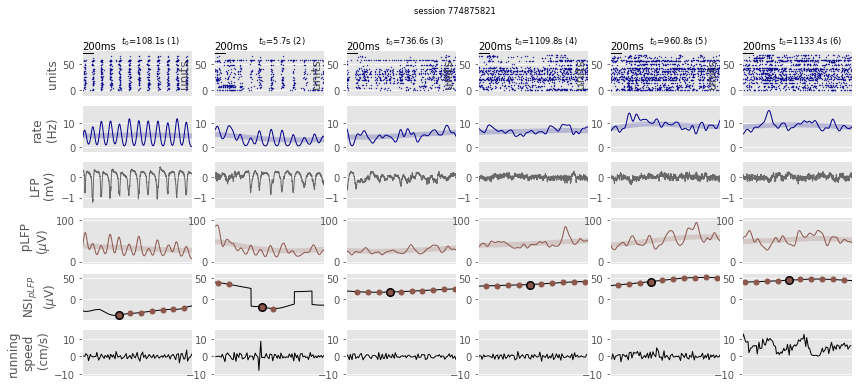

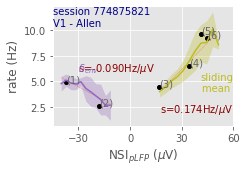

In [36]:
session_index = 5
episode_ids=[135954, 8217, 921798, 1388424, 1201923, 1417806]
fig, _ = plot_sample_data(DATA[session_index], title='session %i' % sessions.index.values[session_index],
                          episode_ids=episode_ids,
                          time_points=[7008.1, 6905.7, 7636.65, 8009.8, 7860.8, 8033.4])
#fig.savefig('../doc/Allen-Session%i-raw.svg' % session_index)
fig, ax = plot_single_session_data(session_index, DATA[session_index], episode_ids)
ax.annotate('$\delta_{env}$', (-30, 6), color=plt.cm.tab10(4))
ax.annotate('sliding\nmean ', (60, 4), ha='right', color=plt.cm.tab10(8))
#fig.savefig('../doc/Allen-Session%i-summary.svg' % session_index)

### Second single session example

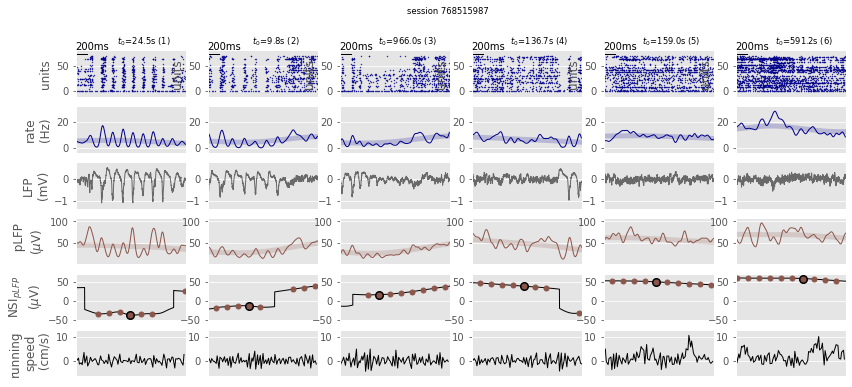

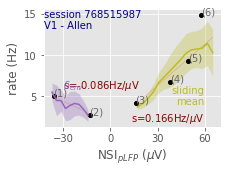

In [37]:
session_index = 2
episode_ids=[31872, 13197, 1208397, 172059, 199947, 740526]
fig, _ = plot_sample_data(DATA[session_index], title='session %i' % sessions.index.values[session_index],
                          episode_ids=episode_ids,
                          time_points=[6924.5, 6909.8, 7866, 7036.7, 7059, 7491.2])
#fig.savefig('../doc/Allen-Session%i-raw.svg' % session_index)
fig, ax = plot_single_session_data(session_index, DATA[session_index], episode_ids)
ax.annotate('$\delta_{env}$', (-30, 6), color=plt.cm.tab10(4))
ax.annotate('sliding\nmean', (60, 4), ha='right', color=plt.cm.tab10(8))
#fig.savefig('../doc/Allen-Session%i-summary.svg' % session_index)

### A third session example

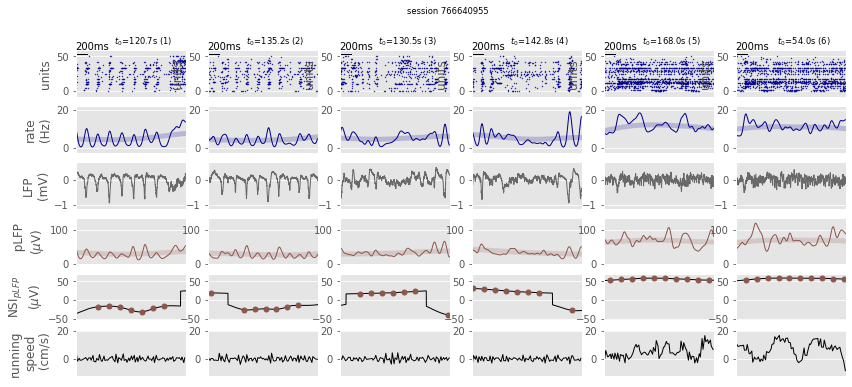

In [604]:
session_index = 0
fig, _ = plot_sample_data(DATA[session_index], title='session %i' % sessions.index.values[session_index],
                          episode_ids=[0,0,0,0,0,0],
                          time_points=[7020.7, 7035.2, 7030.5, 7042.8, 7068, 6954]) # session 1 -- functional_connectivity

#### N.B. to look for the trials at a specific level, use the "look_for_specific_trials" function by passing the level and procision that you want

In [513]:
t0 = 8000
times, indices = look_for_specific_trials(data, 35, 1)
print('-- set of times matching conditions: \n', times[times>t0][:10])
print('-- set of indices matching conditions: \n ', indices[times>t0][:10])

-- set of times matching conditions: 
 [8006.95474869 8010.73954989 8010.93874995 8014.72355114 8018.10995221
 8018.30915227 8018.50835233 8018.7075524  8018.90675246 8019.10595252]
-- set of indices matching conditions: 
  [1383693 1388424 1388673 1393404 1397637 1397886 1398135 1398384 1398633
 1398882]


## Dependency on running speed

In [12]:
running_speed_threshold = 5 # cm/s

NSI_bins = np.linspace(-50, 80, 50)
NSI_hist_running = np.zeros((len(sessions), len(NSI_bins)-1))
NSI_hist_still = np.zeros((len(sessions), len(NSI_bins)-1))
for i, data in enumerate(DATA):
    # we need to resample running speed to map them on validated episodes
    running_speed_resampled = resample_trace(data.t_running_speed, 
                                             data.running_speed, data.t_pLFP)
    running_cond = (np.abs(running_speed_resampled[[data.i_pLFP_vNSI]])>running_speed_threshold)
    NSI_hist_running[i,:] = np.histogram(data.pLFP_vNSI[running_cond], bins=NSI_bins, density=True)[0]
    still_cond = (np.abs(running_speed_resampled[data.i_pLFP_vNSI])<running_speed_threshold)
    NSI_hist_still[i,:] = np.histogram(data.pLFP_vNSI[still_cond], bins=NSI_bins, density=True)[0]

/tmp/ipykernel_2950/1405090397.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  running_cond = (np.abs(running_speed_resampled[[data.i_pLFP_vNSI]])>running_speed_threshold)


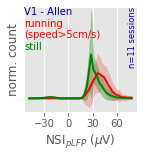

In [13]:
fig, ax = plt.subplots(1, figsize=(2.1,2.3))
x = .5*(NSI_bins[1:]+NSI_bins[:-1])
ax.annotate('V1 - Allen', (0,1), xycoords='axes fraction', color='darkblue', va='top')
ax.annotate('\nrunning\n(speed>5cm/s)', (0,1), xycoords='axes fraction', color='red', va='top')
ax.annotate('\n\n\nstill', (0,1), xycoords='axes fraction', color='green', va='top')
ax.annotate('n=11 sessions', (1,1), xycoords='axes fraction', color='darkblue', va='top', ha='right', rotation=90, size='small')
#ax.plot(x, NSI_hist.mean(axis=0), '-', color='darkblue')
ax.plot(x, NSI_hist_running.mean(axis=0), '-', color='red', lw=2)
ax.plot(x, NSI_hist_still.mean(axis=0), '-', color='green', lw=2)
ax.fill_between(x, NSI_hist_running.mean(axis=0)-NSI_hist_running.std(axis=0), NSI_hist_running.mean(axis=0)+NSI_hist_running.std(axis=0), color='red', alpha=.2)
ax.fill_between(x, NSI_hist_still.mean(axis=0)-NSI_hist_still.std(axis=0), NSI_hist_still.mean(axis=0)+NSI_hist_still.std(axis=0), color='green', alpha=.3)
ax.set_ylabel('norm. count')
ax.set_yticks([])
ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
ax.set_xticks([-30,0,30,60])
plt.tight_layout()
fig.savefig('../doc/V1-NSI-hist-run-still.svg')

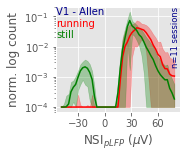

In [629]:
minc=1e-4 # min count
fig, ax = plt.subplots(1, figsize=(2.7,2.3))
x = .5*(NSI_bins[1:]+NSI_bins[:-1])
ax.annotate('V1 - Allen', (0,1), xycoords='axes fraction', color='darkblue', va='top')
ax.annotate('\nrunning', (0,1), xycoords='axes fraction', color='red', va='top')
ax.annotate('\n\nstill', (0,1), xycoords='axes fraction', color='green', va='top')
ax.annotate('n=11 sessions', (1,1), xycoords='axes fraction', color='darkblue', va='top', ha='right', rotation=90, size='small')
for NSI_hist, color in zip([NSI_hist_running, NSI_hist_still], ['red', 'green']):   
    mean = NSI_hist.mean(axis=0)
    mean[mean<minc] = minc
    ax.plot(x, mean, '-', color=color)
    lb, hb = NSI_hist.mean(axis=0)-NSI_hist.std(axis=0), NSI_hist.mean(axis=0)+NSI_hist.std(axis=0)
    lb[lb<minc]=minc
    hb[hb<minc]=minc
    ax.fill_between(x, lb, hb, color=color, alpha=.3)
ax.set_ylabel('norm. log count')
ax.set_yticks([])
ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)')
ax.set_xticks([-30,0,30,60])
plt.yscale('log')
plt.tight_layout()
#fig.savefig('../doc/V1-NSI-log-hist-run-still.svg')

## Accuracy estimate

N.B. not very insightful given the state distribution !!

In [567]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d 

def get_accuracy(data,
                 rate_tolerance=3,
                 with_fig=True):
    
    pop_act_NSI_resampled = resample_trace(data.t_pop_act, 
                                           data.pop_act_NSI, data.t_pLFP)
    

    x, y = data.pLFP_NSI[data.i_pLFP_vNSI], pop_act_NSI_resampled[data.i_pLFP_vNSI]
    cond = ((x>0) & (y>0)) | ((x<0) & (y<0))

    lin = np.polyfit(x[cond], y[cond], 1)
    
    accuracy_cond = np.abs(y-np.polyval(lin, x))<rate_tolerance
    
    accuracy = np.sum(accuracy_cond)/len(y)    
    summary = {'all':len(y),
               'wrong':np.sum(~accuracy_cond),
               'pos-pos':np.sum(~accuracy_cond & (x>0) & (y>0)),
               'pos-neg':np.sum(~accuracy_cond & (x>0) & (y<0)),
               'neg-pos':np.sum(~accuracy_cond & (x<0) & (y>0)),
               'neg-neg':np.sum(~accuracy_cond & (x<0) & (y<0))}
    
    if with_fig:
        fig, ax = plt.subplots(1, figsize=(2,2))
        ax.set_title('accuracy=%.1f%%'%(100*accuracy), fontsize=11)
        x = np.linspace(x.min(), x.max())
        ax.plot(data.pLFP_NSI[data.i_pLFP_vNSI], 
                 pop_act_NSI_resampled[data.i_pLFP_vNSI], 'o', lw=1, ms=0.2)
        ax.fill_between(x, np.polyval(lin, x)-rate_tolerance, np.polyval(lin, x)+rate_tolerance, color='g', alpha=.3)
        ax.plot(x, np.polyval(lin, x), 'k-')
        ax.set_ylabel('NSI$_{\,rate}$ (Hz)')
        ax.set_xlabel('NSI$_{\,pLFP}$ ($\mu$V)')
        return fig, ax, summary
    else:
        return summary
    
#fig, ax, summary = get_accuracy(DATA[5])
#fig.savefig('../doc/accuracy-example-1.png')

In [571]:
V1_rate_comp_misclassification = {'pos-neg':[],
                                  'neg-pos':[],
                                  'pos-pos':[],
                                  'neg-neg':[]}
average_accuracy = []
for data in DATA:
    summary = get_accuracy(data, with_fig=False,
                          rate_tolerance=3)
    for key in V1_rate_comp_misclassification:
        V1_rate_comp_misclassification[key].append(100*summary[key]/summary['wrong'])
    average_accuracy.append(100*(1-summary['wrong']/summary['all']))
print('average accuracy: %.1f +/- %.1f %%' % (np.mean(average_accuracy), np.std(average_accuracy)))

average accuracy: 91.8 +/- 3.8 %


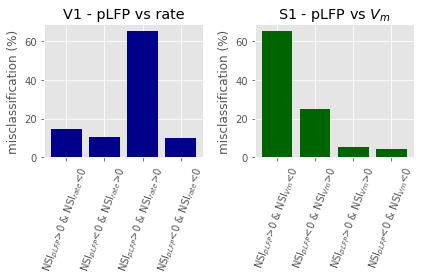

In [630]:
S1_Vm_comp_misclassification = {'pos-neg':65.3,
                                'neg-pos':25.0,
                                'pos-pos':5.4,
                                'neg-neg':4.3}

fig, AX = plt.subplots(1, 2, figsize=(6,4))
for i, key in enumerate(V1_rate_comp_misclassification):
    AX[0].bar([i], np.mean(V1_rate_comp_misclassification[key]), color='darkblue')
    AX[1].bar([i], [S1_Vm_comp_misclassification[key]], color='darkgreen')
AX[0].set_ylabel('misclassification (%)')
AX[0].set_title('V1 - pLFP vs rate')
AX[1].set_ylabel('misclassification (%)')
AX[1].set_title('S1 - pLFP vs $V_m$')
AX[0].set_xticks(range(4))
AX[0].set_xticklabels(['NSI$_{pLFP}$>0 & NSI$_{rate}$<0', 'NSI$_{pLFP}$<0 & NSI$_{rate}$>0', 'NSI$_{pLFP}$>0 & NSI$_{rate}$>0', 'NSI$_{pLFP}$<0 & NSI$_{rate}$<0'], rotation=70)
AX[1].set_xticks(range(4))
AX[1].set_xticklabels(['NSI$_{pLFP}$>0 & NSI$_{Vm}$<0', 'NSI$_{pLFP}$<0 & NSI$_{Vm}$>0', 'NSI$_{pLFP}$>0 & NSI$_{Vm}$>0', 'NSI$_{pLFP}$<0 & NSI$_{Vm}$<0'], rotation=70)
plt.tight_layout()
#fig.savefig('../doc/accuracy-summary.svg')